Examining the method using InPlanePhaseEncoding to how the image changes

In [3]:
import dicom
import os
import numpy as np
import glob
import cv2
%matplotlib inline
import matplotlib.pyplot as py
import SimpleITK as sitk
from PIL import Image
from scipy.misc import imrotate

In [4]:
#Kaggle Training Images Path
Kaggle_train = "/Users/laurawilke/Documents/DSE/lwilke/Capstone/Data/Sample data ( kaggle)/*/study/*/*"

In [5]:
#Get all the file names for the Kaggle Images
lstFilesKaggle_train=glob.glob(Kaggle_train)

In [6]:
#Get a list of all the paths for the sax images
lstFilesKaggle_train_sax = [s for s in lstFilesKaggle_train if "sax" in s]

In [7]:
#Read the first image; Picked a file that is COL Oriented
img=dicom.read_file(lstFilesKaggle_train[0])

In [8]:
#Obtain the pixel array of the image
img_array=img.pixel_array

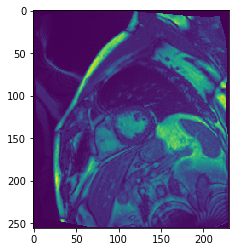

In [9]:
#Plot the Image
py.imshow(img.pixel_array)

In [13]:
#If InPlanePhaseEncodingDirection is COL then 
#transpose the image and flip it (roate counterclockwise 90 degrees)
if img.InPlanePhaseEncodingDirection =='COL':
    img_new=cv2.transpose(img_array)
    py.imshow(img_new)
    img_new = cv2.flip(img_new, 0)
    py.imshow(img_new)
else:
    print 'Row Oriented'

Row Oriented


In [14]:
#Creating a function of the above code. Read in the dicom image
def Orientation_M1 (img):
    if img.InPlanePhaseEncodingDirection=='COL':
        new_img=cv2.transpose(img.pixel_array)
        #py.imshow(img_new)
        new_img = cv2.flip(new_img, 0)
        return new_img
    else:
    #    print 'Row Oriented'
        return img.pixel_array

Original Image Shape: (256, 230) Rotated Image Shape: (256, 230)


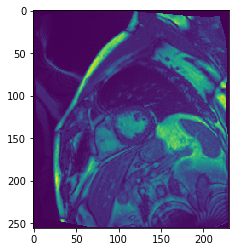

In [15]:
#Make sure function works
rotated_img=Orientation_M1(img)
py.imshow(rotated_img)
print "Original Image Shape: %s Rotated Image Shape: %s" %(str(img_array.shape), str(rotated_img.shape))

The COL oriented image is rotated counter clockwise 90 degrees. The shape of the image changes due to the transpose. 

In [16]:
#Code from the 1st Place DSB. 
#Attempting to see how the image is rotate and how it differs from above
def getAlignImg(t,label = None):#!!!notice, only take uint8 type for the imrotate function!!!
    f = lambda x:np.asarray([float(a) for a in x]);
    o = f(t.ImageOrientationPatient);
    o1 = o[:3];
    o2 = o[3:];
    oh = np.cross(o1,o2);
    or1 = np.asarray([0.6,0.6,-0.2]);
    o2new = np.cross(oh,or1);
    theta = np.arccos(np.dot(o2,o2new)/np.sqrt(np.sum(o2**2)*np.sum(o2new**2)))*180/3.1416;
    theta = theta * np.sign(np.dot(oh,np.cross(o2,o2new)));
    im_max = np.percentile(t.pixel_array.flatten(),99);
    res = imrotate(np.array(np.clip(np.array(t.pixel_array,dtype=np.float)/im_max*256,0,255),dtype=np.uint8),theta);
    if label is None:
        return res;
    else:
        lab = imrotate(label,theta);
        return res,lab

In [17]:
o=img.ImageOrientationPatient

In [18]:
o1 = o[:3];
o2 = o[3:];

In [19]:
oh = np.cross(o1,o2);
o1, o2, oh

(['0.6412707562768', '0.6609488316973', '-0.3897671856663'],
 ['-0.5193911680303', '5.80088222E-08', '-0.8545366080936'],
 array([-0.56480495,  0.75043097,  0.34329102]))

In [20]:
or1 = np.asarray([0.6,0.6,-0.2])
o2new = np.cross(oh,or1)
o2new

array([-0.35606081,  0.09301362, -0.78914155])

In [21]:
theta = np.arccos(np.dot(o2,o2new)/np.sqrt(np.sum([i ** 2 for i in o2])*np.sum([i ** 2 for i in o2new])))*180/3.1416

In [22]:
theta

9.30088724733411

In [23]:
theta = theta * np.sign(np.dot(oh,np.cross(o2,o2new)))
theta

-9.30088724733411

In [24]:
im_max = np.percentile(img.pixel_array.flatten(),99)
im_max

346.0

In [25]:
res = imrotate(np.array(np.clip(np.array(img.pixel_array,dtype=np.float)/im_max*256,0,255),dtype=np.uint8),theta);
res_no_im_max = imrotate(np.array((np.array(img.pixel_array,dtype=np.float))),theta);
res_theta_90 = imrotate(np.array((np.array(img.pixel_array,dtype=np.float))),90)

Image Shape: (256, 230)


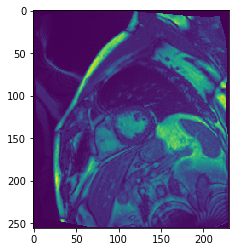

In [26]:
print "Image Shape: %s" %(str(img.pixel_array.shape))
py.imshow(img.pixel_array)

Image Shape: (256, 230)


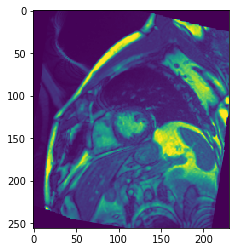

In [27]:
print "Image Shape: %s" %(str(res.shape))
py.imshow(res)

Image Shape: (256, 230)


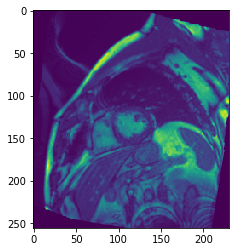

In [28]:
print "Image Shape: %s" %(str(res_no_im_max.shape))
py.imshow(res_no_im_max)

Image Shape: (256, 230)


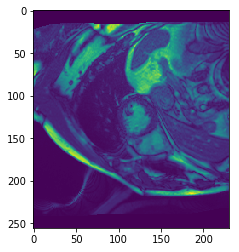

In [29]:
print "Image Shape: %s" %(str(res_theta_90.shape))
py.imshow(res_theta_90)

Brief Comparison between the InPlanePhaseEncoding method and the ImageOrientationMethod. (A Different notebook will be a more in depth analysis to se what is happening)

A theta is calculated which will be the theata that the image is rotated around. 

1st Image: Original DICOM Slice Image
2nd Image: Image is rotated around theta (29 degrees). It appears that the rotation occurs counter clockwise. (same direction as the method above). It looks like the im_max calculation changes the contrast / color of the image (need to look into this more)
3rd Image: The Image rotated around theta without the coloring change of im_max calculation.
4th Image: Image rotated around theta when theta=90. This image is rotated so it is the same orientation as the image from the method above (3rd Image from the top). However, this image appears to be cropped in the bottom right corner.

The shape of all of these images are all the same, the original dimensions of the the dicom image. 

After rotating the image so it is ROW oriented, then rescale the image

In [31]:
#Get the size of the pixel for the image
scale = img.PixelSpacing[0]
print scale

1.5625


In [32]:
#Resize the rotated image so each pixel has the same area
img_scaled = cv2.resize(rotated_img, (0, 0), fx=scale, fy=scale)

Image Shape: (400, 359)


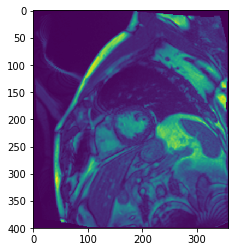

In [33]:
print "Image Shape: %s" %(str(img_scaled.shape))
py.imshow(img_scaled)

In [34]:
img={}
rot_img=[]
PS=[]
for i in range(15):
    rand=np.random.randint(0,len(lstFilesKaggle_train_sax))
    tmp_img=dicom.read_file(lstFilesKaggle_train_sax[rand])
    PS.append(tmp_img.PixelSpacing[0])
    tmp_img_array=tmp_img.pixel_array
    img[lstFilesKaggle_train_sax[rand]]=tmp_img
    rotate=Orientation_M1(tmp_img)
    rot_img.append(rotate)

In [35]:
PS

['1.5625',
 '1.484375',
 '1.484375',
 '1.5625',
 '1.484375',
 '1.5625',
 '1.5625',
 '1.5625',
 '1.5625',
 '1.484375',
 '1.5625',
 '1.5625',
 '1.5625',
 '1.484375',
 '1.5625']

In [36]:
#Function of Rescaling the pixels
def reScale(img, scale):
    return cv2.resize(rotated_img, (0, 0), fx=scale, fy=scale)

In [37]:
rescaled_img_0=reScale(rot_img[0],PS[0])
rescaled_img_1=reScale(rotated_img[1],PS[1])

In [38]:
files=img.keys()

Image Shape: (256, 230)


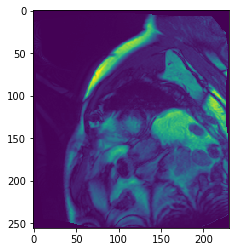

In [39]:
print "Image Shape: %s" %(str(img[files[0]].pixel_array.shape))
py.imshow(img[files[0]].pixel_array)

Image Shape: (400, 359)


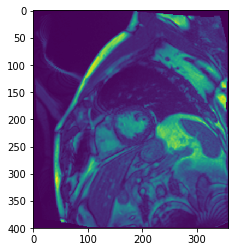

In [40]:
print "Image Shape: %s" %(str(rescaled_img_0.shape))
py.imshow(rescaled_img_0)

Image Shape: (256, 192)


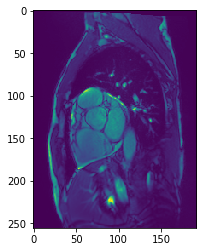

In [42]:
print "Image Shape: %s" %(str(img[files[1]].pixel_array.shape))
py.imshow(img[files[1]].pixel_array)

Image Shape: (380, 341)


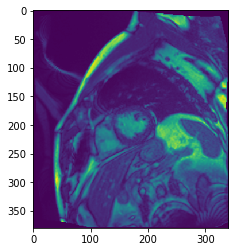

In [41]:
print "Image Shape: %s" %(str(rescaled_img_1.shape))
py.imshow(rescaled_img_1)

The size of the image is altered, increases in the x and y directions. 

In [43]:
def get_square_crop(img, base_size=256, crop_size=256):
    res = img
    height, width = res.shape
    if height < base_size:
        diff = base_size - height
        extend_top = diff / 2
        extend_bottom = diff - extend_top
        res = cv2.copyMakeBorder(res, extend_top, extend_bottom, 0, 0, borderType=cv2.BORDER_CONSTANT, value=0)
        height = base_size

    if width < base_size:
        diff = base_size - width
        extend_top = diff / 2
        extend_bottom = diff - extend_top
        res = cv2.copyMakeBorder(res, 0, 0, extend_top, extend_bottom, borderType=cv2.BORDER_CONSTANT, value=0)
        width = base_size

    crop_y_start = (height - crop_size) / 2
    crop_x_start = (width - crop_size) / 2
    res = res[crop_y_start:(crop_y_start + crop_size), crop_x_start:(crop_x_start + crop_size)]
    return res

Image Shape: (256, 256)


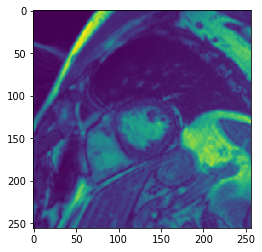

In [46]:
sq_img_org=get_square_crop(img_scaled)
print "Image Shape: %s" %(str(sq_img_org.shape))
py.imshow(sq_img_org) 

Image Shape: (256, 256)


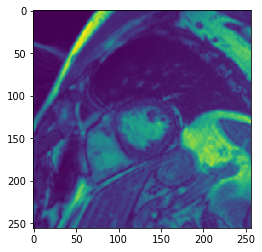

In [48]:
sq_img_0=get_square_crop(rescaled_img_0)
print "Image Shape: %s" %(str(sq_img_0.shape))
py.imshow(sq_img_0)

Image Shape: (256, 256)


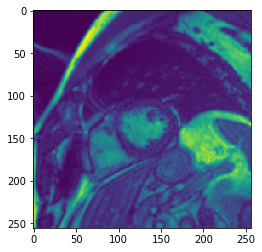

In [49]:
sq_img_1=get_square_crop(rescaled_img_1)
print "Image Shape: %s" %(str(sq_img_1.shape))
py.imshow(sq_img_1)

Image Shape: (256, 256)


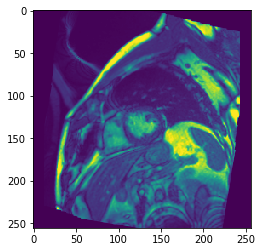

In [52]:
# Seeing what the get_sq_crop does to the GetAligned Oriented Image
#res_rescaled=reScale(res, ) #Need to figure out pixel spacing of res image to rescale it? 
sq_img_res=get_square_crop(res)
print "Image Shape: %s" %(str(sq_img_res.shape))
py.imshow(sq_img_res)